# Projekt Laminattheorie

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Hilfsfunktionen

In [2]:
def calc_Q(alpha): #berechnet die Transformationsmatrix Q
    Q = np.array([
        [np.cos(alpha)**2, np.sin(alpha)**2, 0, np.sin(2*alpha), 0, 0],
        [np.sin(alpha)**2, np.cos(alpha)**2, 0, -np.sin(2*alpha), 0, 0],
        [0, 0, 1, 0, 0, 0],
        [-1/2*np.sin(2*alpha), 1/2*np.sin(2*alpha), 0, np.cos(2*alpha), 0, 0],
        [0, 0, 0, 0, -np.cos(alpha), np.sin(alpha)],
        [0, 0, 0, 0, np.sin(alpha), np.cos(alpha)],
    ])

    return Q

In [3]:
def calc_Q_st(alpha): #berechnet die Transformationsmatrix Q*
    Q_st = np.array([
        [np.cos(alpha)**2, np.sin(alpha)**2, 0, 1/2*np.sin(2*alpha), 0, 0],
        [np.sin(alpha)**2, np.cos(alpha)**2, 0, -1/2*np.sin(2*alpha), 0, 0],
        [0, 0, 1, 0, 0, 0],
        [-np.sin(2*alpha), np.sin(2*alpha), 0, np.cos(2*alpha), 0, 0],
        [0, 0, 0, 0, -np.cos(alpha), np.sin(alpha)],
        [0, 0, 0, 0, np.sin(alpha), np.cos(alpha)],
    ])
    return Q_st

In [4]:
def calc_Geff(G_M, phi_c, G_xy): #berechnet G_eff
    return G_M/(1-np.sqrt(phi_c)*(1-(G_M/G_xy)))

In [5]:
def calc_Chamis(E_M, nu_M, E_1f, E_2f, nu_21I, phi, G_M, G_12, G_23): #berechnet die Größen laut Chamis-Gleichungen
    phi_c = phi
    phi_M = 1 - phi
    E_1eff = E_1f * phi_c + E_M * phi_M
    E_2eff = E_M/(1- np.sqrt(phi_c)*(1-(E_M/E_2f)))
    G_12eff = calc_Geff(G_M, phi_c, G_12)
    G_23eff = calc_Geff(G_M, phi_c, G_23)

    nu_21eff = nu_21I * phi_c + nu_M * phi_M
    return E_1eff, E_2eff, nu_21eff, G_12eff, G_23eff

In [6]:
def calc_D(E_1eff, E_2eff, nu_21eff, G_12eff, G_23eff, nu_M): #D = C^-1 wir berechnet
    D = np.array([
    [1/E_1eff,          -nu_21eff/E_1eff,   -nu_21eff/E_1eff,   0,          0,          0],
    [-nu_21eff/E_1eff,  1/E_2eff,           -nu_M/E_2eff,       0,          0,          0],
    [-nu_21eff/E_1eff,  -nu_M/E_2eff,       1/E_2eff,           0,          0,          0],
    [0,                 0,                  0,                  1/G_12eff,  0,          0],
    [0,                 0,                  0,                  0,          1/G_23eff,  0],
    [0,                 0,                  0,                  0,          0,          1/G_12eff]
    ])

    return D

In [7]:
def calc_C(E_1eff, E_2eff, nu_21eff, G_12eff, G_23eff, nu_M, Q, Q_st): #C wird aus D durch Invertieren berechnet
    D = calc_D(E_1eff, E_2eff, nu_21eff, G_12eff, G_23eff, nu_M)
    C_prime = np.linalg.inv(D)

    return np.linalg.inv(Q) @ C_prime @ Q_st

In [8]:
def calc_part_integration(j, C_st, x3k, x3k_1): #j=0 für A, j=1 für B, j=2 für D
    return 1/(j+1) * (x3k**(j+1)-x3k_1**(j+1)) * C_st

In [9]:
def calc_integration(d, C_list, j, anz): #berechnet die gesamte Integration (Summation)
    sum = 0
    x3 = np.arange(-anz/2*d, (anz+1)/2*d, d)
    for x in range(len(C_list)):
        sum += calc_part_integration(j, C_list[x], x3[x+1], x3[x])
    return sum

In [10]:
def calc_ABD_matrix(C_list, d, anz):
    for x in range(3):
        match x:
            case 0: A = calc_integration(d, C_list, x, anz)
            case 1: B = calc_integration(d, C_list, x, anz)
            case 2: D = calc_integration(d, C_list, x, anz)
    ABD = np.block([[A,B],
             [B,D]])
    return ABD

In [11]:
def calc_C_st(C):
    indices = [0,1,3]
    mtx = np.zeros((3, 3))
    k_shift = 0
    j_shift = 0
    for k in indices:
        if k == 3: 
            k_shift = 2 #k_shift Index für C*
        else:
            k_shift = k
        for j in indices:
            if j == 3: 
                j_shift = 2
            else:
                j_shift = j
            mtx[k_shift][j_shift] = C[k][j]
    return mtx

In [12]:
def calculate_stiffness_for_different_angles(phi, alpha, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f):
    G_M = E_M/(2*(1+nu_M))
    
    Q = calc_Q(alpha)
    Q_st = calc_Q_st(alpha)

    E_1eff, E_2eff, nu_21eff, G_12eff, G_23eff = calc_Chamis(E_M, nu_M, E_1f, E_2f, nu_21f, phi, G_M, G_12f, G_23f)

    C = np.array(calc_C(E_1eff, E_2eff, nu_21eff, G_12eff, G_23eff, nu_M, Q, Q_st))

    C_st = calc_C_st(C)

    return C_st, C[0][0], C[3][3]

## Hauptfunktion

In [13]:
def calc_ABD_entries(phi, alpha_list, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz):
    C_st_seven = []
    for x in range(anz):
        C_st_seven.append(calculate_stiffness_for_different_angles(phi, alpha_list[x]*2*np.pi/360, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f)[0])
    ABD = calc_ABD_matrix(C_st_seven, d, anz)
    return ABD[0][0], ABD[1][1], ABD[2][2], ABD[3][3], ABD[4][4], ABD[5][5], ABD[0][1]

## Visualisierung Laminat

In [14]:
phi = 0.6
nu_M = 0.3
E_M = 3
E_1f = 300
E_2f = 20
nu_21f = 0.2
G_12f = 40
G_23f = 40
d = 1
anz = 7

## Membrane Stiffness $\pm \psi$

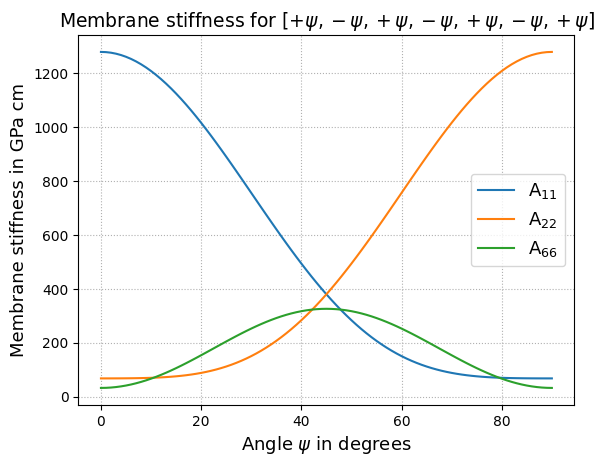

In [15]:
A11 = []
A22 = []
A66 = []
# A12 = []

ys = np.arange(0,91,1)

for y in ys:
    list = [y,-y,y,-y,y,-y,y]
    # list = [-y,y,-y,y,-y,y,-y]
    A11.append(calc_ABD_entries(phi, list, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz)[0])
    A22.append(calc_ABD_entries(phi, list, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz)[1])
    A66.append(calc_ABD_entries(phi, list, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz)[2])
    # A12.append(main(phi, list, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz)[6])

# plt.plot(ys, A11/A11[0])
# plt.plot(ys, A22/A22[0])
# plt.plot(ys, A66/A66[0])

plt.plot(ys, A11, label=r'A$_{11}$')
plt.plot(ys, A22, label=r'A$_{22}$')
plt.plot(ys, A66, label=r'A$_{66}$')
# plt.plot(ys, A12, label=r'A$_{12}$')
plt.title(r'Membrane stiffness for [$+\psi,-\psi,+\psi,-\psi,+\psi,-\psi,+\psi$]', size=13.5)
plt.xlabel(r'Angle $\psi$ in degrees', size=13)
plt.ylabel('Membrane stiffness in GPa cm', size=13)
plt.legend(prop={'size': 13})
plt.grid(ls=':')
plt.show()

# plt.plot(ys, [A11[x]/A22[x] for x in range(len(A11))])

## Membrance Stiffness $\alpha = \frac{\pi}{4}$

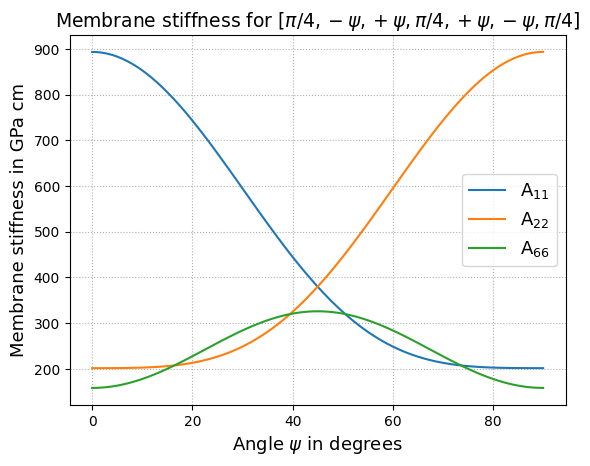

In [16]:
A11_n = []
A22_n = []
A66_n = []

ys = np.arange(0,91,1)

for y in ys:
    list = [45,-y,y,45,y,-y,45]
    A11_n.append(calc_ABD_entries(phi, list, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz)[0])
    A22_n.append(calc_ABD_entries(phi, list, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz)[1])
    A66_n.append(calc_ABD_entries(phi, list, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz)[2])

plt.plot(ys, A11_n, label=r'A$_{11}$')
plt.plot(ys, A22_n, label=r'A$_{22}$')
plt.plot(ys, A66_n, label=r'A$_{66}$')
plt.title(r'Membrane stiffness for [$\pi/4,-\psi,+\psi,\pi/4,+\psi,-\psi,\pi/4$]', size=13.5)
plt.xlabel(r'Angle $\psi$ in degrees', size=13)
plt.ylabel('Membrane stiffness in GPa cm', size=13)
plt.legend(prop={'size': 13})
plt.grid(ls=':')

## Membrance Stiffness $\alpha = 0$

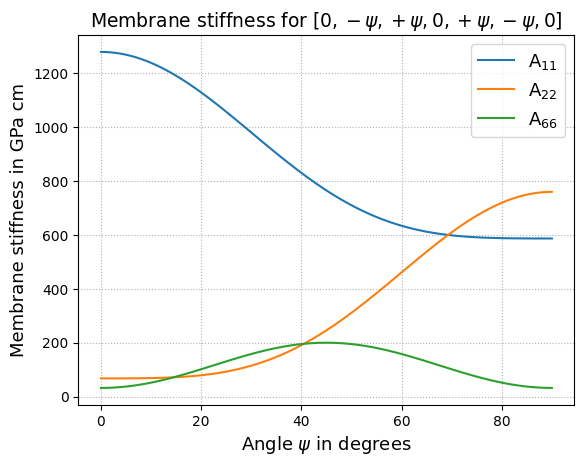

In [17]:
A11_n = []
A22_n = []
A66_n = []

ys = np.arange(0,91,1)

for y in ys:
    list = [0,-y,y,0,y,-y,0]
    A11_n.append(calc_ABD_entries(phi, list, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz)[0])
    A22_n.append(calc_ABD_entries(phi, list, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz)[1])
    A66_n.append(calc_ABD_entries(phi, list, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz)[2])

plt.plot(ys, A11_n, label=r'A$_{11}$')
plt.plot(ys, A22_n, label=r'A$_{22}$')
plt.plot(ys, A66_n, label=r'A$_{66}$')
plt.title(r'Membrane stiffness for [$0,-\psi,+\psi,0,+\psi,-\psi,0$]', size=13.5)
plt.xlabel(r'Angle $\psi$ in degrees', size=13)
plt.ylabel('Membrane stiffness in GPa cm', size=13)
plt.legend(prop={'size': 13})
plt.grid(ls=':')

## Membrane Stiffness varying $\alpha$

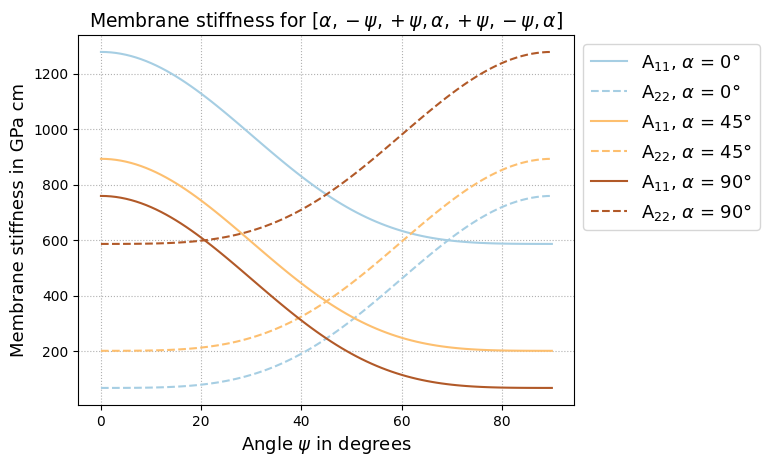

In [18]:
def three_fixed(alpha, col):
    A11_n = []
    A22_n = []
    A66_n = []

    ys = np.arange(0,91,1)
    for y in ys:
        list = [alpha,-y,y,alpha,y,-y,alpha]
        A11_n.append(calc_ABD_entries(phi, list, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz)[0])
        A22_n.append(calc_ABD_entries(phi, list, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz)[1])
        A66_n.append(calc_ABD_entries(phi, list, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz)[2])

    plt.plot(ys, A11_n, label=rf'A$_{{{11}}}$, $\alpha$ = {alpha}°', color=col)
    plt.plot(ys, A22_n, label=rf'A$_{{{22}}}$, $\alpha$ = {alpha}°', color = col, ls="--")
    # plt.plot(ys, A66_n, label=r'A$_{66}$')
    plt.title(r'Membrane stiffness for [$\alpha,-\psi,+\psi,\alpha,+\psi,-\psi,\alpha$]', size=13.5)
    plt.xlabel(r'Angle $\psi$ in degrees', size=13)
    plt.ylabel('Membrane stiffness in GPa cm', size=13)
    plt.legend(prop={'size': 13}, bbox_to_anchor=[1, 1])
    plt.grid(ls=':')

cmap = plt.get_cmap('Paired', 3)

for x in range(3):
    three_fixed(x*45, cmap(x))

## Membrane Stiffness influence Outer Layer

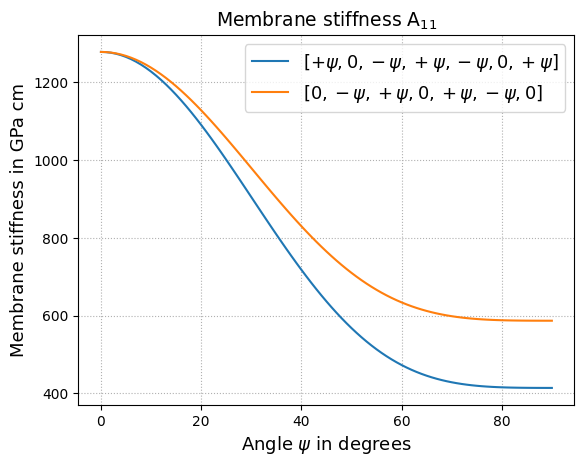

In [19]:
A11_1 = []
A11_2 = []

ys = np.arange(0,91,1)

for y in ys:
    list = [[y,0,-y,y,-y,0,y], [0,-y,y,0,y,-y,0]] #[0,y,-y,0,-y,y,0], [y,-y,0,y,0,-y,y]
    A11_1.append(calc_ABD_entries(phi, list[0], nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz)[0])
    A11_2.append(calc_ABD_entries(phi, list[1], nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz)[0])

plt.plot(ys, A11_1, label=r'[$+\psi,0,-\psi,+\psi,-\psi,0,+\psi$]')
plt.plot(ys, A11_2, label=r'[$0,-\psi,+\psi,0,+\psi,-\psi,0$]')
plt.title(r'Membrane stiffness A$_{11}$', size=13.5)
plt.xlabel(r'Angle $\psi$ in degrees', size=13)
plt.ylabel('Membrane stiffness in GPa cm', size=13)
plt.legend(prop={'size': 13})
plt.grid(ls=':')

In [20]:
# D11 = []
# D22 = []
# D66 = []
# for y in np.arange(0,91,1):
#     list = [y,-y,y,-y,y,-y,y]
#     D11.append(main(phi, list, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz)[3])
#     D22.append(main(phi, list, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz)[4])
#     D66.append(main(phi, list, nu_M, E_M, E_1f, E_2f, nu_21f, G_12f, G_23f, d, anz)[5])

# plt.plot(np.arange(0,91,1), D11)
# plt.plot(np.arange(0,91,1), D22)
# plt.plot(np.arange(0,91,1), D66)

## Visualisierung einzelne Schicht

In [21]:
def plot_C(C_abcd, abcd, alpha):
    fig = plt.figure()
    ax = fig.add_subplot(projection='polar')
    ax.set_thetamin(0)
    ax.set_thetamax(90)
    label_plot = rf'$\mathbb{{C}}_{{{abcd}}}$'
    plt.plot(alpha, C_abcd, label=label_plot)

    rticks = ax.get_yticks()[0:-1]
    for r in rticks:
        ax.text(np.pi/2, r, f'{int(r)}  ', ha='right', va='center')
    ax.set_xlabel('Stiffness in GPa', labelpad=20)
    plt.legend()

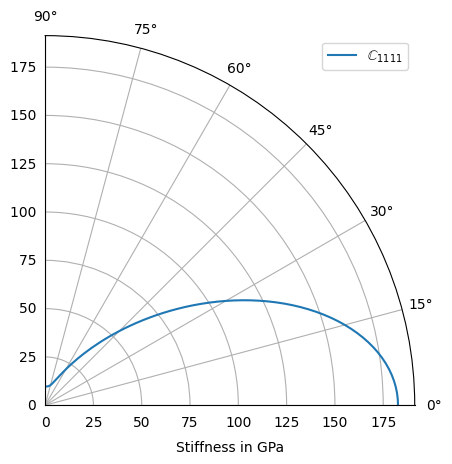

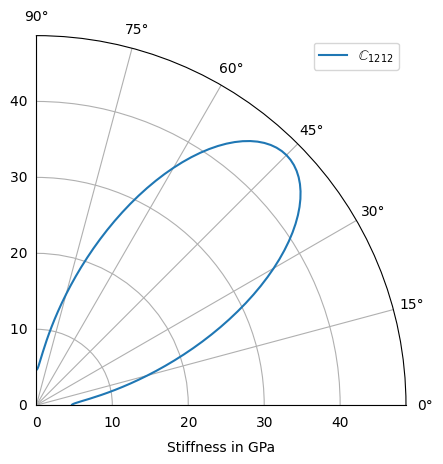

In [22]:
C_1111 = [calculate_stiffness_for_different_angles(0.6, x, 0.3, 3, 300, 20, 0.2, 40, 40)[1] for x in np.arange(0,2*np.pi,2*np.pi/360)]
C_1212 = [calculate_stiffness_for_different_angles(0.6, x, 0.3, 3, 300, 20, 0.2, 40, 40)[2] for x in np.arange(0,2*np.pi,2*np.pi/360)]
alpha = [2*np.pi/360*x for x in range(360)]

plot_C(C_1111, '1111', alpha)
plot_C(C_1212, '1212', alpha)